In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore",category=FutureWarning)

In [3]:
# Load processed dataset
train = pd.read_csv('processed_train.csv', parse_dates=['date'], low_memory=False)


In [5]:
# Baseline Model - Naïve Forecasting
train['naive_forecast'] = train.groupby(['store_nbr', 'family'])['sales'].shift(1)


In [7]:
# Prepare training data
features = ['day', 'week', 'month', 'year', 'day_of_week', 'is_holiday', 'is_weekend', 
            'is_gov_payday', 'earthquake_impact', 'sales_lag_7', 'sales_lag_30', 
            'rolling_mean_7', 'rolling_std_7', 'avg_store_sales']
X = train[features].dropna()
y = train.loc[X.index, 'sales']

In [9]:
# Split into training and validation sets
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]


In [11]:
y_train_sample = y_train.iloc[-10000:]  # Use only the last 10,000 records


In [13]:
# Train ARIMA Model
arima_model = ARIMA(y_train, order=(2,1,0))
arima_model_fit = arima_model.fit(low_memory=True)
arima_preds = arima_model_fit.forecast(steps=len(y_val))


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [15]:
rf_model = RandomForestRegressor(
    n_estimators=50,  # Reduce trees
    max_depth=10,  # Limit depth
    n_jobs=-1,  # Enable parallelism
    bootstrap=False,  # Reduce overhead
    random_state=42
)

X_sample, y_sample = X_train.sample(50000, random_state=42), y_train.loc[X_train.sample(50000, random_state=42).index]
rf_model.fit(X_sample, y_sample)
rf_preds = rf_model.predict(X_val)


In [17]:
rf_model.fit(X_sample, y_sample)

RandomForestRegressor(bootstrap=False, max_depth=10, n_estimators=50, n_jobs=-1,
                      random_state=42)

In [23]:
rf_model.predict(X_sample)

array([191.5412496 ,   3.24605501, 313.21990291, ..., 489.70811932,
        39.93198059,  15.44235662])

In [25]:
# Train XGBoost Model
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_val)

In [27]:
# Evaluation Metrics
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - RMSE: {rmse:.2f}, MAPE: {mape:.2%}, R2: {r2:.2f}")
    

print("Model Evaluation:")
if 'arima_preds' in locals():
    evaluate_model(y_val, arima_preds, "ARIMA")
else:
    print("ARIMA predictions not found.")
if "rf_model" in locals():
    rf_preds = rf_model.predict(X_val)
else:
    print("Random Forest model not trained.")

evaluate_model(y_val, arima_preds, "ARIMA")
evaluate_model(y_val, rf_preds, "Random Forest")
evaluate_model(y_val, xgb_preds, "XGBoost")

Model Evaluation:
ARIMA - RMSE: 1411.32, MAPE: 10195183152728457216.00%, R2: -0.06
ARIMA - RMSE: 1411.32, MAPE: 10195183152728457216.00%, R2: -0.06
Random Forest - RMSE: 431.90, MAPE: 975344682013655424.00%, R2: 0.90
XGBoost - RMSE: 307.43, MAPE: 728251545701144448.00%, R2: 0.95


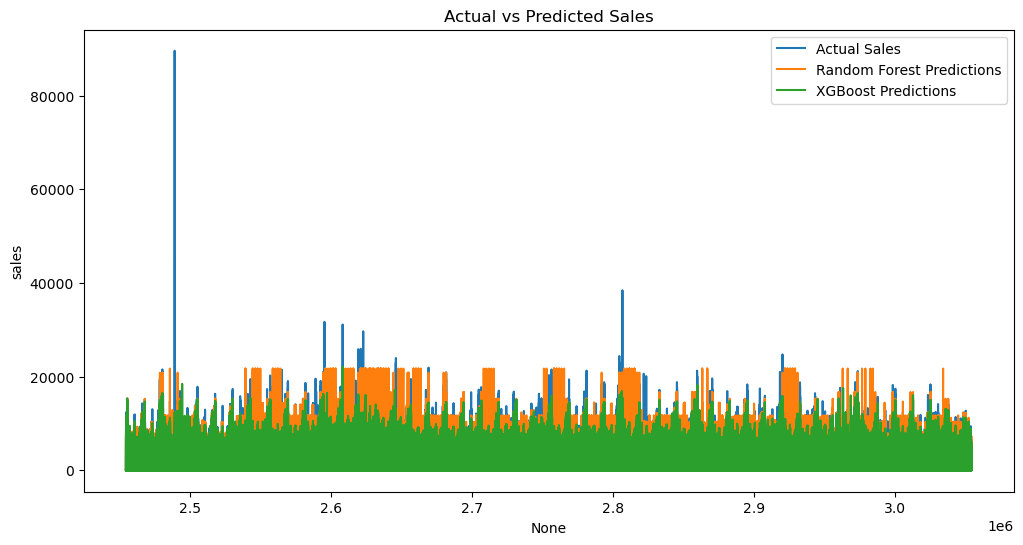

Model training, forecasting, and evaluation completed.


In [29]:
# Visualization
plt.figure(figsize=(12, 6))
sns.lineplot(x=y_val.index, y=y_val, label='Actual Sales')
sns.lineplot(x=y_val.index, y=rf_preds, label='Random Forest Predictions')
sns.lineplot(x=y_val.index, y=xgb_preds, label='XGBoost Predictions')
plt.legend()
plt.title('Actual vs Predicted Sales')
plt.show()

print("Model training, forecasting, and evaluation completed.")